# Convert SardiNIA Access Database to NIH Public Release File

# Initial declarations

In [1]:
pwd

u'/Users/colettace/david_projects/sardiNIA/latest'

In [2]:
import pandas as pd
from subprocess import check_output
from cStringIO import StringIO

In [3]:
pd.__version__

u'0.19.2'

# Load Chris's field name mapping file

In [4]:
conversion = pd.read_excel( 'Coletta_Conversion.xlsx')

In [5]:
len(conversion)

1206

In [6]:
conversion = conversion[ conversion.ignore == 'no']

In [7]:
len(conversion)

1168

In [8]:
conversion.drop( 'ignore', axis=1, inplace=True )

# Load NIA Public Release File and PRF DB description

In [9]:
prf = pd.read_csv( '2015-10-30-Sardinia-TAB.txt', sep='\t')

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,29,30,72,73,76,77,80,81,99,101,105,106,114,135,166,203,340,367,394,395,424,428,590,598,745,746,747,748,749,750,751,752,753,754) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
prf.shape

(19977, 1038)

In [11]:
us_db_description = pd.read_excel( '2015-10-30-Sardinia-Data-Description_cleaned.xls')
columns = list( us_db_description['Column Name'])

# Load Sardinia's Microsoft Access Files

In [12]:
new_db_path = 'DbSardiniaIV20161220.mdb'

## Get Names of tables in mdb files

In [13]:
table_names = check_output( ['mdb-tables', new_db_path]).strip().split()

In [14]:
len(table_names)

26

In [15]:
table_names = [ (_ , 'DbSardiniaIV20161220.mdb') for _ in table_names ]

Add supplemental ecocardo clinical data:

In [16]:
table_names.append( ('ECARDIO', 'ecocardio.csv') )

# Load Italian Data

In [17]:
print '\t'.join( ["Nrows", "Nindivs", "Nfields", "TableName" ] )

all_tables = {}

for table_name, db_name in table_names:
    
    # Pull the table
    if db_name == 'ecocardio.csv':
        df = pd.read_csv( 'ecocardio.csv' )
    else:
        df = pd.read_csv( StringIO( check_output( ['mdb-export', db_name, table_name ] ) ) )
    
    # how many unique individual ids in this table?
    try:
        individual_id_set = set( df.ID_INDIVIDUAL )
    except AttributeError:
        individual_id_set = set( df.id_individual )
    
    # Get table shape
    rows, cols = df.shape

    print "{}\t{}\t{}\t{}".format( rows, len( individual_id_set ), cols, table_name )

    all_tables[ table_name ] = df

Nrows	Nindivs	Nfields	TableName
1945	1945	99	SPHIGMOCOR_OLD
4705	4705	15	AUDIOMETRY
4705	4705	29	EXAMINATION
2806	1750	26	SPHIGMOCOR_HRV
6140	1764	54	SPHIGMOCOR_PWA
6655	1671	35	SPHIGMOCOR_PWV
4705	4705	21	ECG
4705	4705	34	HOLTER
4705	4705	43	SPIROMETER
2499	2499	7	CAROTID
4705	4705	14	VASCULAR
2247	2238	4	PWV
4705	4705	53	BLOOD
4705	4705	138	DISEASECHECKLIST


/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13,14,133) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4705	4705	141	DISEASES
4705	4705	94	DISEASESCHECKLIST_n
4705	4705	40	EXAMINATION_BIS
4705	4705	16	INDIVIDUAL
4705	4705	37	MEDHISTORY
4705	4705	9	MEDICATIONS
4705	4705	23	MMSE
4705	4705	36	OTHERMEDICATION2_NEW
4285	2006	8	OTHERMEDICATIONS
4705	4705	28	PHYSICAL_ACTIVITY
4705	4705	22	PHYSICAL_TEST
4705	4705	11	URINE
3127	3121	181	ECARDIO


In [18]:
len(all_tables)

27

## Remove tables that are obsolete, unused, or ones we don't know what to do with

In [19]:
ignore_tables = [ 'SPHIGMOCOR_HRV', 'SPHIGMOCOR_PWA', 'SPHIGMOCOR_PWV', 'OTHERMEDICATIONS', 'DISEASECHECKLIST' ]
for tname in ignore_tables:
    try:
        del all_tables[ tname ]
        print "deleted", tname
    except KeyError:
        print "skipping", tname

deleted SPHIGMOCOR_HRV
deleted SPHIGMOCOR_PWA
deleted SPHIGMOCOR_PWV
deleted OTHERMEDICATIONS
deleted DISEASECHECKLIST


# Table-wise join

Instead of individual-wise join, which is time-consuming

1. Make sure rows are unique to individuals in wave 4 (PWV, ECARDIO)
2. Reindex all tables in ID_INDIVIDUAL
3. drop field names that aren't translatable
4. translate the ones that are
5. Join one by one

## PWV

In [20]:
pwv = all_tables['PWV']

In [21]:
pwv_counts = pwv.ID_INDIVIDUAL.value_counts()

In [22]:
pwv_counts = zip( pwv_counts.index, pwv_counts )

In [23]:
repeated_pwv_measurements = [ _id for _id, count in pwv_counts if count >1]

In [24]:
repeated_pwv_measurements

[27004, 12982, 3421, 1110, 1761, 1111, 30050, 3258, 1197]

In [25]:
for _id, df in iter( pwv[ pwv.ID_INDIVIDUAL.isin( repeated_pwv_measurements ) ].groupby( 'ID_INDIVIDUAL') ):
    print _id, df.iloc[0].name
    print df

1110 222
     ID_INDIVIDUAL               Date   Value  Quality
222           1110  11/17/08 00:00:00  1888.0      2.0
223           1110  05/29/12 00:00:00  1301.3      3.0
1111 224
     ID_INDIVIDUAL               Date  Value  Quality
224           1111  05/14/09 00:00:00  611.8      2.8
225           1111  04/23/12 00:00:00  740.5      2.8
1197 247
     ID_INDIVIDUAL               Date  Value  Quality
247           1197  02/23/10 00:00:00  328.3      2.4
248           1197  10/01/12 00:00:00  645.8      3.0
1761 368
     ID_INDIVIDUAL               Date   Value  Quality
368           1761  02/11/10 00:00:00     NaN      2.0
369           1761  09/14/12 00:00:00  1030.2      2.5
3258 619
     ID_INDIVIDUAL               Date   Value  Quality
619           3258  03/09/10 00:00:00  2217.0      2.0
620           3258  11/22/12 00:00:00   909.0      2.5
3421 642
     ID_INDIVIDUAL               Date  Value  Quality
642           3421  12/17/08 00:00:00    NaN      2.0
643           3421 

In [26]:
for _id, df in iter( pwv[ pwv.ID_INDIVIDUAL.isin( repeated_pwv_measurements ) ].groupby( 'ID_INDIVIDUAL') ):
    pwv.drop(df.iloc[0].name, inplace=True)

In [27]:
pwv_counts = pwv.ID_INDIVIDUAL.value_counts()
pwv_counts = zip( pwv_counts.index, pwv_counts )
repeated_pwv_measurements = [ _id for _id, count in pwv_counts if count >1]

In [28]:
repeated_pwv_measurements

[]

## ECARDIO

### Drop non-wave 4 participants

In [29]:
# get cannonical index
index = sorted( list( all_tables['DISEASES'].ID_INDIVIDUAL ))

In [30]:
# drop any rows whose ID_INDIVIDUAL is not in the cannonical index
ecardio = all_tables['ECARDIO']

In [31]:
len(ecardio)

3127

In [32]:
not_in_wave4 = set(ecardio.ID_INDIVIDUAL) - set(index)

In [33]:
ecardio = ecardio[ -ecardio.ID_INDIVIDUAL.isin( not_in_wave4 ) ]

In [34]:
len(ecardio)

2874

In [35]:
len(all_tables['ECARDIO'])

3127

In [36]:
all_tables['ECARDIO'] = ecardio

In [37]:
len(all_tables['ECARDIO'])

2874

### If there are multiple readings for a given individual, drop the earliest one

In [38]:
ecardio.VisitDate = ecardio.VisitDate.map( lambda x: pd.to_datetime( x.split()[0], format='%d/%m/%Y', errors='ignore') )

In [39]:
ecardio_counts = ecardio.ID_INDIVIDUAL.value_counts()
ecardio_counts = zip( ecardio_counts.index, ecardio_counts )
repeated_ecardio_measurements = [ _id for _id, count in ecardio_counts if count > 1 ]

In [40]:
repeated_ecardio_measurements

[2678, 11642, 9629, 2355, 12928, 414]

In [41]:
from IPython.display import display

In [42]:
for _id, df in iter( ecardio[ ecardio.ID_INDIVIDUAL.isin( repeated_ecardio_measurements ) ].groupby( 'ID_INDIVIDUAL') ):
    display(df.sort_values(by='VisitDate'))

,ID_INDIVIDUAL,SEX,AGE,VisitDate,STRUMENTO,PP_Unique_Id,BP_DIA,BP_SYS,BSA,HOHeight,...,Ischemia_lat,Ischemia_set,Cornell,Destrocardia,Necrosi_ant,Necrosi_inf,Necrosi_lat,Necrosi_set,Note,Note Usa
1596,414,M,17.0,2008-09-03,SIEMENS,2008.9.3.12.4.1,80.0,128.0,1.0,158.0,...,0,0,30.0,0,0,0,0,0,NaN,NaN
57,414,M,22.5,2014-02-27,ATL,NaN,80.0,118.0,NaN,NaN,...,0,0,30.0,0,0,0,0,0,NaN,NaN


,ID_INDIVIDUAL,SEX,AGE,VisitDate,STRUMENTO,PP_Unique_Id,BP_DIA,BP_SYS,BSA,HOHeight,...,Ischemia_lat,Ischemia_set,Cornell,Destrocardia,Necrosi_ant,Necrosi_inf,Necrosi_lat,Necrosi_set,Note,Note Usa
2960,2355,M,18.7,2011-09-15,SIEMENS,2011.9.15.19.28.21,44.0,118.0,2.0,170.0,...,0,0,26.0,0,0,0,0,0,NaN,NaN
3048,2355,M,20.5,2013-06-19,SIEMENS,2013.6.19.13.34.19,60.0,136.0,2.0,173.0,...,0,0,26.0,0,0,0,0,0,NaN,NaN


,ID_INDIVIDUAL,SEX,AGE,VisitDate,STRUMENTO,PP_Unique_Id,BP_DIA,BP_SYS,BSA,HOHeight,...,Ischemia_lat,Ischemia_set,Cornell,Destrocardia,Necrosi_ant,Necrosi_inf,Necrosi_lat,Necrosi_set,Note,Note Usa
979,2678,F,62.5,2008-08-28,SIEMENS,2008.8.28.13.49.7,80.0,138.0,2.0,155.0,...,0,0,16.0,0,0,0,0,0,NaN,NaN
1397,2678,F,67.4,2013-07-25,SIEMENS,2013.7.25.12.38.35,70.0,138.0,2.0,155.0,...,0,0,16.0,0,0,0,0,0,NaN,NaN


,ID_INDIVIDUAL,SEX,AGE,VisitDate,STRUMENTO,PP_Unique_Id,BP_DIA,BP_SYS,BSA,HOHeight,...,Ischemia_lat,Ischemia_set,Cornell,Destrocardia,Necrosi_ant,Necrosi_inf,Necrosi_lat,Necrosi_set,Note,Note Usa
2223,9629,M,41.3,2008-07-31,SIEMENS,2008.7.31.11.34.3,72.0,130.0,2.0,174.0,...,0,0,24.0,0,0,0,0,0,NaN,NaN
1879,9629,M,46.3,2013-07-26,SIEMENS,2013.7.26.12.33.23,88.0,146.0,2.0,174.0,...,0,0,24.0,0,0,0,0,0,NaN,NaN


,ID_INDIVIDUAL,SEX,AGE,VisitDate,STRUMENTO,PP_Unique_Id,BP_DIA,BP_SYS,BSA,HOHeight,...,Ischemia_lat,Ischemia_set,Cornell,Destrocardia,Necrosi_ant,Necrosi_inf,Necrosi_lat,Necrosi_set,Note,Note Usa
2092,11642,M,70.1,2011-02-25,SIEMENS,2011.2.25.13.11.29,68.0,110.0,2.0,154.0,...,0,0,20.0,0,0,0,0,0,NaN,NaN
2974,11642,M,72.8,2013-11-05,SIEMENS,2013.11.5.19.58.50,70.0,116.0,2.0,154.0,...,0,0,20.0,0,0,0,0,0,NaN,NaN


,ID_INDIVIDUAL,SEX,AGE,VisitDate,STRUMENTO,PP_Unique_Id,BP_DIA,BP_SYS,BSA,HOHeight,...,Ischemia_lat,Ischemia_set,Cornell,Destrocardia,Necrosi_ant,Necrosi_inf,Necrosi_lat,Necrosi_set,Note,Note Usa
3011,12928,F,27.0,2011-03-25,SIEMENS,2011.3.25.11.44.49,70.0,114.0,1.0,151.0,...,0,0,6.0,0,0,0,0,0,NaN,NaN
2800,12928,F,28.7,2012-12-20,SIEMENS,2012.12.20.18.14.49,70.0,138.0,1.0,150.0,...,0,0,6.0,0,0,0,0,0,NaN,NaN


In [43]:
for _id, df in iter( ecardio[ ecardio.ID_INDIVIDUAL.isin( repeated_ecardio_measurements ) ].groupby( 'ID_INDIVIDUAL') ):
    ecardio.drop( df.sort_values(by='VisitDate').iloc[0].name, inplace=True )

In [44]:
ecardio_counts = ecardio.ID_INDIVIDUAL.value_counts()
ecardio_counts = zip( ecardio_counts.index, ecardio_counts )
repeated_ecardio_measurements = [ _id for _id, count in ecardio_counts if count > 1 ]

In [45]:
repeated_ecardio_measurements

[]

In [46]:
ecardio is all_tables['ECARDIO']

True

## Reindex all tables to ID_INDIVIDUAL

Make sure each row is unique to an individual

In [47]:
all_tables.keys()

['DISEASES',
 'PHYSICAL_TEST',
 'DISEASESCHECKLIST_n',
 'EXAMINATION',
 'ECG',
 'URINE',
 'BLOOD',
 'VASCULAR',
 'OTHERMEDICATION2_NEW',
 'SPHIGMOCOR_OLD',
 'PHYSICAL_ACTIVITY',
 'PWV',
 'MEDICATIONS',
 'MMSE',
 'ECARDIO',
 'INDIVIDUAL',
 'AUDIOMETRY',
 'SPIROMETER',
 'MEDHISTORY',
 'HOLTER',
 'EXAMINATION_BIS',
 'CAROTID']

In [48]:
for table_name, table in all_tables.items():
    try:
        table.index = table.ID_INDIVIDUAL
        table.drop( 'ID_INDIVIDUAL', axis=1, inplace=True )
        all_tables[ table_name ] = table
    except AttributeError:
        table.index = table.id_individual
        table.drop( 'id_individual', axis=1, inplace=True )
        all_tables[ table_name ] = table
        
    print len( list( table.index ) ), len( set( table.index ) ), table_name

4705 4705 DISEASES
4705 4705 PHYSICAL_TEST
4705 4705 DISEASESCHECKLIST_n
4705 4705 EXAMINATION
4705 4705 ECG
4705 4705 URINE
4705 4705 BLOOD
4705 4705 VASCULAR
4705 4705 OTHERMEDICATION2_NEW
1945 1945 SPHIGMOCOR_OLD
4705 4705 PHYSICAL_ACTIVITY
2238 2238 PWV
4705 4705 MEDICATIONS
4705 4705 MMSE
2868 2868 ECARDIO
4705 4705 INDIVIDUAL
4705 4705 AUDIOMETRY
4705 4705 SPIROMETER
4705 4705 MEDHISTORY
4705 4705 HOLTER
4705 4705 EXAMINATION_BIS
2499 2499 CAROTID


# DISEASECHECKLIST_n Table Augmentation

Pull info DISEASES table and put into DISEASECHECKLIST table

Marco Masala Explanation:

From: Marco Masala [mailto:marco.masala@gmail.com] 
Sent: Wednesday, February 15, 2017 6:04 AM
To: Coletta, Christopher (NIH/NIA/IRP) [E] <christopher.coletta@nih.gov>
Cc: Schlessinger, David (NIH/NIA/IRP) [E] <SchlessingerD@grc.nia.nih.gov>; Nagaraja, Ramaiah (NIH/NIA/IRP) [E] <NagarajaR@grc.nia.nih.gov>; Michele Marongiu <michele.marongiu@irgb.cnr.it>; edoardo.fiorillo@irgb.cnr.it; Francesco Cucca <fcucca@uniss.it>
Subject: Re: Which disease traits to use?
 
The table to be referenced is DISEASES. The fields in DISEASECHECKLIST already in DISEASES may be incorrect. Physicians update only the fields in the form DISEASES

the two tables come from two different forms. In the first (DISEASES) volunteers are asked all the questions, one by one. If emerging diseases that were not present in the first form, the doctor inserts them in the second. Over the years some questions were added in the first form and have not been deleted from the second. (And a few questions, for reasons I never understood, have always existed in both forms). 
 
Regarding the differences, please note that in the first form may be available 3 answers (yes, no, I do not know) and in the second only 2 (yes no). Moreover, often physicians who have indicated a Diseases in the first form, do not bother to put it in the second. The first form (DISEASES) should therefore contain the correct answers.



In [49]:
pull_these = ['Acromegaly', 'Alzheimer', 'Arthritis', 'Asthma', 'Astigmatism', 'Bipolar', 
              'Bronchitis', 'Cataract', 'Cirrhosis', 'Colitis', 'Colorblind', 'Crohn', 
              'Dementias', 'Depressive', 'Dialisis', 'Eczema', 'Emphysema', 'Glaucoma', 
              'Gout', 'Hashimoto', 'Hemophilia', 'Hyperthyroidism', 'Hypothyroidism', 
              'Les', 'Macular', 'Myasthenia', 'Mypia', 'Osteoporosis', 'Pancreatitis', 
              'Parkinson', 'Psoriasis', 'Retinitis', 'Stones', 'Subst_Abuse']

In [50]:
pull_these = [_.upper() for _ in pull_these]

In [51]:
len(pull_these)

34

### All the missing fields are contained in the DISEASES table and none are in the DISEASESCHECKLIST table

In [52]:
set( pull_these ) - set( all_tables['DISEASES'].columns )

set()

In [53]:
len(set( pull_these ) - set( all_tables['DISEASESCHECKLIST_n'].columns ))

34

In [54]:
subset = all_tables['DISEASES'][ pull_these ]

## Eliminate Don't Know option

Because I don't know what to do with the I don't know responses, I'm going to arbitrarily call them "no" until I'm given a definitive answer either way. We'll call the the Null hypothesis approach.

In [55]:
# Per database description file:
# 0=yes; 1=no; 2=don't know; 3=null
subset.stack().value_counts()

1.0    151689
0.0      7148
2.0       827
dtype: int64

In [56]:
all_tables['DISEASESCHECKLIST_n'].stack().value_counts()

1.0                     354144
0.0                      77888
RINITE ALLERGICA             1
autoimmune                   1
ALLERGENI ALIMENTARI         1
dtype: int64

In [57]:
subset = subset.copy()

In [58]:
subset.replace( 2.0, 1.0, inplace=True)

In [59]:
subset.stack().value_counts()

1.0    152516
0.0      7148
dtype: int64

In [60]:
all_tables['DISEASESCHECKLIST_n'].shape

(4705, 93)

In [61]:
subset.shape

(4705, 34)

In [62]:
all_tables['DISEASESCHECKLIST_n'] = all_tables['DISEASESCHECKLIST_n'].merge( subset, left_index=True, right_index=True)

In [63]:
all_tables['DISEASESCHECKLIST_n'].shape

(4705, 127)

# Convert field names to NIA style, and drop the rest

In [64]:
for table_name, table in all_tables.items():

    table_conversion = conversion[ conversion.ita_prefix == table_name ]
    # First, narrow down the ita fields that have a conversion rule
    eng_names = list(table_conversion.eng)
    ita_names = list(table_conversion.ita)
    ita_select_names = [ _ for _ in list(table.columns) if _ in ita_names ]
    eng_select_names = [ eng_names[ ita_names.index(_) ] for _ in ita_select_names ]
    
    # Subselect columns we want
    all_tables[ table_name ] = all_tables[ table_name ][ ita_select_names ]
    # change the names from italian to english
    all_tables[ table_name ].columns = eng_select_names

# JOIN!!!!!

In [65]:
all_wave_4 = None
for table_name, table in all_tables.items():
    print table_name, table.shape
    if all_wave_4 is None:
        all_wave_4 = table
        continue
    all_wave_4 = all_wave_4.merge( table, how='outer', left_index=True, right_index=True )
    print "ALL", all_wave_4.shape

DISEASES (4705, 140)
PHYSICAL_TEST (4705, 21)
ALL (4705, 161)
DISEASESCHECKLIST_n (4705, 127)
ALL (4705, 288)
EXAMINATION (4705, 28)
ALL (4705, 316)
ECG (4705, 20)
ALL (4705, 336)
URINE (4705, 10)
ALL (4705, 346)
BLOOD (4705, 52)
ALL (4705, 398)
VASCULAR (4705, 12)
ALL (4705, 410)
OTHERMEDICATION2_NEW (4705, 22)
ALL (4705, 432)
SPHIGMOCOR_OLD (1945, 98)
ALL (4705, 530)
PHYSICAL_ACTIVITY (4705, 27)
ALL (4705, 557)
PWV (2238, 3)
ALL (4705, 560)
MEDICATIONS (4705, 8)
ALL (4705, 568)
MMSE (4705, 22)
ALL (4705, 590)
ECARDIO (2868, 135)
ALL (4705, 725)
INDIVIDUAL (4705, 15)
ALL (4705, 740)
AUDIOMETRY (4705, 14)
ALL (4705, 754)
SPIROMETER (4705, 42)
ALL (4705, 796)
MEDHISTORY (4705, 34)
ALL (4705, 830)
HOLTER (4705, 33)
ALL (4705, 863)
EXAMINATION_BIS (4705, 34)
ALL (4705, 897)
CAROTID (2499, 6)
ALL (4705, 903)


In [66]:
all_wave_4.shape

(4705, 903)

In [67]:
all_wave_4.insert( 0, 'Wave', [4]*len(all_wave_4))

In [68]:
all_wave_4.insert( 0, 'id_individual', all_wave_4.index )

In [69]:
all_wave_4.shape

(4705, 905)

## Prepare Age columns

In [70]:
all_wave_4.drop( 'Age at First Visit', axis=1, inplace=True )

In [71]:
all_wave_4.drop( 'Age at Second Visit', axis=1, inplace=True )

In [72]:
all_wave_4.drop( 'Age at Third Visit', axis=1, inplace=True )

In [73]:
all_wave_4.shape

(4705, 902)

### Rename column "Age at Fourth Visit" to just "Age"

In [74]:
new_columns = list( all_wave_4.columns )
new_columns.index( 'Age at Fourth Visit' )

729

In [75]:
new_columns = [ 'Age' if _ == 'Age at Fourth Visit' else _ for _ in new_columns ]

In [76]:
new_columns.index( 'Age' )

729

In [77]:
all_wave_4.columns = new_columns

### Convert sex column from 'M' and 'F' to 1 and 0, respectively

In NIA DB, sex has numeric representation

In [78]:
new_columns = list( all_wave_4.columns )
new_columns.index( 'Sex' )

730

In [79]:
new_columns = [ 'SexOLD' if _ == 'Sex' else _ for _ in new_columns ]

In [80]:
all_wave_4.columns = new_columns

In [81]:
all_wave_4[ 'Sex' ] = [ 0 if _ == 'F' else 1 for _ in list( all_wave_4.SexOLD ) ]

In [82]:
all_wave_4.dtypes[ 'Sex' ]

dtype('int64')

In [83]:
all_wave_4.dtypes[ 'SexOLD' ]

dtype('O')

In [84]:
all_wave_4.drop( 'SexOLD', axis=1, inplace=True )

## Visit column

In [85]:
new_wave4 = all_wave_4

In [86]:
old_wave4 = prf[ prf.Wave == 4 ]

In [87]:
old_wave4.Visit.value_counts()

4.0    2825
2.0     355
3.0     323
1.0     211
Name: Visit, dtype: int64

In [88]:
old_waves123 = prf[ prf.Wave != 4 ]

In [89]:
wave1 =  prf[ prf.Wave == 1 ]

In [90]:
len( wave1.id_individual ), len( set( wave1.id_individual))

(6165, 6165)

In [91]:
wave2 =  prf[ prf.Wave == 2 ]
len( wave2.id_individual ), len( set( wave2.id_individual))

(5256, 5251)

In [92]:
wave3 =  prf[ prf.Wave == 3 ]
len( wave3.id_individual ), len( set( wave3.id_individual))

(4842, 4842)

In [93]:
all_ids_all_waves = list( set( wave1.id_individual)) + list( set( wave2.id_individual)) + list( set( wave3.id_individual))

In [94]:
visit = [ all_ids_all_waves.count(_) + 1 for _ in list( new_wave4.index ) ]

In [95]:
len(visit)

4705

In [96]:
new_wave4['Visit'] = visit

In [97]:
new_wave4['Visit'].value_counts()

4    3375
2     571
3     537
1     222
Name: Visit, dtype: int64

In [98]:
len(new_wave4.index)

4705

# Join to previous PRF 

This is an easy way to add the empty columns

In [99]:
old_waves123 = prf[ prf.Wave != 4 ]

In [100]:
all_joined = pd.concat([old_waves123, new_wave4], axis=0, ignore_index=True)

In [101]:
all_joined.shape

(20968, 1058)

In [102]:
list(all_joined.columns).index('id_individual')

859

# Write Putative New DB to file

In [103]:
all_joined.to_csv( '2017-02-09-Sardinia-TAB.txt', sep='\t')

In [104]:
ls -lh 2017-02-09-Sardinia-TAB.txt

-rw-r--r--  1 colettace  staff    56M Feb 15 17:34 2017-02-09-Sardinia-TAB.txt


In [105]:
ls -lh 2015-10-30-Sardinia-TAB.txt

-rw-r--r--  1 colettace  staff    36M Nov 18  2015 2015-10-30-Sardinia-TAB.txt


# Integrity Check

## Create lists of new columns and shared columns, new rows and shared rows between previous database release and current db release.

In [106]:
new_wave4_joined = all_joined[ all_joined.Wave == 4 ]

In [107]:
new_wave4_joined.shape

(4705, 1058)

In [108]:
old_wave4.shape

(3714, 1038)

In [109]:
new_columns = set( new_wave4_joined.columns ) - set( old_wave4.columns )

In [110]:
mutual_columns = set( new_wave4_joined.columns ) & set( old_wave4.columns )

In [111]:
len(set(new_wave4_joined.id_individual)), len(new_wave4_joined.id_individual)

(4705, 4705)

In [112]:
len(set(old_wave4.id_individual)), len(old_wave4.id_individual)

(3714, 3714)

In [113]:
old_wave4.index = old_wave4.id_individual
new_wave4_joined.index = new_wave4_joined.id_individual

In [114]:
new_rows = set( new_wave4_joined.index ) - set( old_wave4.index )

In [115]:
len(new_rows)

993

In [116]:
missing_rows = set( old_wave4.index ) - set( new_wave4_joined.index )

In [117]:
len(missing_rows)

2

In [118]:
missing_rows

{3825, 12986}

In [119]:
mutual_rows = set( old_wave4.index ) & set( new_wave4_joined.index )

In [120]:
len(mutual_rows)

3712

In [121]:
len(mutual_rows) + len(new_rows) == len( new_wave4_joined )

True

In [122]:
len(mutual_rows) + len(missing_rows) == len( old_wave4 )

True

# Create visual representation

Do comparison in 3 parts

1. New rows, same columns
2. New columns, all rows
3. Overlapped part

"Empty" below implies an empty cell, containing a blank string or a NaN value

Colors:
* Blue: Row or column didn't exist before or was empty, is non-empty now
* Black: Was empty before or row or column didn't exist, is empty now.
* Green: Had a value before and current value matches previous value (exact match or np.isclose resolves to true for numeric data)
* Red: Had a value before, now is empty
* Yellow: Had a value before, current value doesn't match old value


Load data into a Pandas Panel, which is a 3D DataFrame, which we'll then convert to RGB pixel values by calling as_matrix()

In [123]:
%matplotlib inline

In [124]:
import matplotlib.pyplot as plt

In [125]:
import numpy as np

In [126]:
n_rows, n_cols = new_wave4_joined.shape

In [127]:
comparisons = pd.Panel( items=['r', 'g', 'b'], major_axis=new_wave4_joined.index,
                       minor_axis=new_wave4_joined.columns, dtype=float)

print "rbefore", comparisons['r'].count().sum()
# initialize
comparisons['r'].loc[ :, : ] = 0
comparisons['g'].loc[ :, : ] = 0
comparisons['b'].loc[ :, : ] = 0
print "rafter", comparisons['r'].count().sum()

rbefore 0
rafter 4977890


In [128]:
comparisons.shape

(3, 4705, 1058)

In [129]:
comparisons.as_matrix().shape

(3, 4705, 1058)

In [130]:
4705.0/96

49.010416666666664

In [131]:
1058.0/96

11.020833333333334

In [132]:
def show_visualization( comparison_panel ):
    fig, ax = plt.subplots( figsize=(12,50) )
    rows, cols = comparison_panel['r'].shape
    show_me = np.empty( (rows, cols, 3) )
    show_me[:,:,0] = comparison_panel['r'].values
    show_me[:,:,1] = comparison_panel['g'].values
    show_me[:,:,2] = comparison_panel['b'].values
    ax.imshow( show_me )
    return fig

In [133]:
def update_comparison_figure( comparison_fig, chan, rows, cols, boolean_vals, quiet=False ):
    if cols == None:
        # Use all of them then
        cols = comparison_fig[ chan ].columns
    existing_pixels = comparison_fig[ chan ].loc[ rows, cols ].values.astype(bool)
    n_total_rows, n_total_cols = comparison_fig[ chan ].shape
    n_total_cells = n_total_rows * n_total_cols
    assert existing_pixels.shape == boolean_vals.shape

    n = len(rows)* len(cols)
    print "Updating {} channel: {} rows, {} cols, {} total cells".format( chan, len(rows), len(cols), n )
    incount = boolean_vals.sum().sum()
    print "\tIncoming data: {} true cells, {:0.2f}%".format( incount, float(incount)/n * 100 )
    count = comparison_fig[ chan ].loc[ rows, cols ].sum().sum()
    all_count = comparison_fig[ chan ].sum().sum()
    print "\tExisting data: selection: {} px on, {:0.2f}%, whole channel: {} px on {:0.2f}%".format( 
        count, float(count)/n * 100, all_count, float(all_count)/n_total_cells * 100 )
    comparison_fig[ chan ].loc[ rows, cols ] = \
        ( boolean_vals | existing_pixels ).astype(float)
    count = comparison_fig[ chan ].loc[ rows, cols ].sum().sum()
    all_count = comparison_fig[ chan ].sum().sum()
    print "\tFigure after update: {} px on, {:0.2f}% of selection, {:0.2f}% of channel; whole channel {} px on, {:0.2f}%".format(
        count, float(count)/n * 100, float(count)/n_total_cells * 100, all_count, float(all_count)/n_total_cells*100)        

## check that the comparisons figure is completely empty

In [134]:
comparisons['b'].sum()

Age                       0.0
CesdItem1                 0.0
CesdItem10                0.0
CesdItem11                0.0
CesdItem12                0.0
CesdItem13                0.0
CesdItem14                0.0
CesdItem15                0.0
CesdItem16                0.0
CesdItem17                0.0
CesdItem18                0.0
CesdItem19                0.0
CesdItem2                 0.0
CesdItem20                0.0
CesdItem3                 0.0
CesdItem4                 0.0
CesdItem5                 0.0
CesdItem6                 0.0
CesdItem7                 0.0
CesdItem8                 0.0
CesdItem9                 0.0
CesdPersonRated           0.0
EcocardioCubedEdv         0.0
EcocardioCubedIvsd        0.0
EcocardioCubedLvidd       0.0
EcocardioCubedLvpwd       0.0
EcocardioDtiAal           0.0
EcocardioDtiAam           0.0
EcocardioDtiEEal          0.0
EcocardioDtiEEam          0.0
                         ... 
rxCatNeurolettici         0.0
rxCatNitrates             0.0
rxCatParki

In [135]:
comparisons['b'].sum().sum()

0.0

# Step 1: New Rows, All columns

Add blue where the new rows are not NaN

In [136]:
newly_filled = -pd.isnull( new_wave4_joined.loc[ new_rows, : ] )

In [137]:
newly_filled.shape

(993, 1058)

In [138]:
newly_filled.sum().sum()

464415

In [139]:
993*1058

1050594

In [140]:
update_comparison_figure( comparisons, chan='b', rows=new_rows, cols=None, boolean_vals=newly_filled )

Updating b channel: 993 rows, 1058 cols, 1050594 total cells
	Incoming data: 464415 true cells, 44.20%
	Existing data: selection: 0.0 px on, 0.00%, whole channel: 0.0 px on 0.00%
	Figure after update: 464415.0 px on, 44.20% of selection, 9.33% of channel; whole channel 464415.0 px on, 9.33%


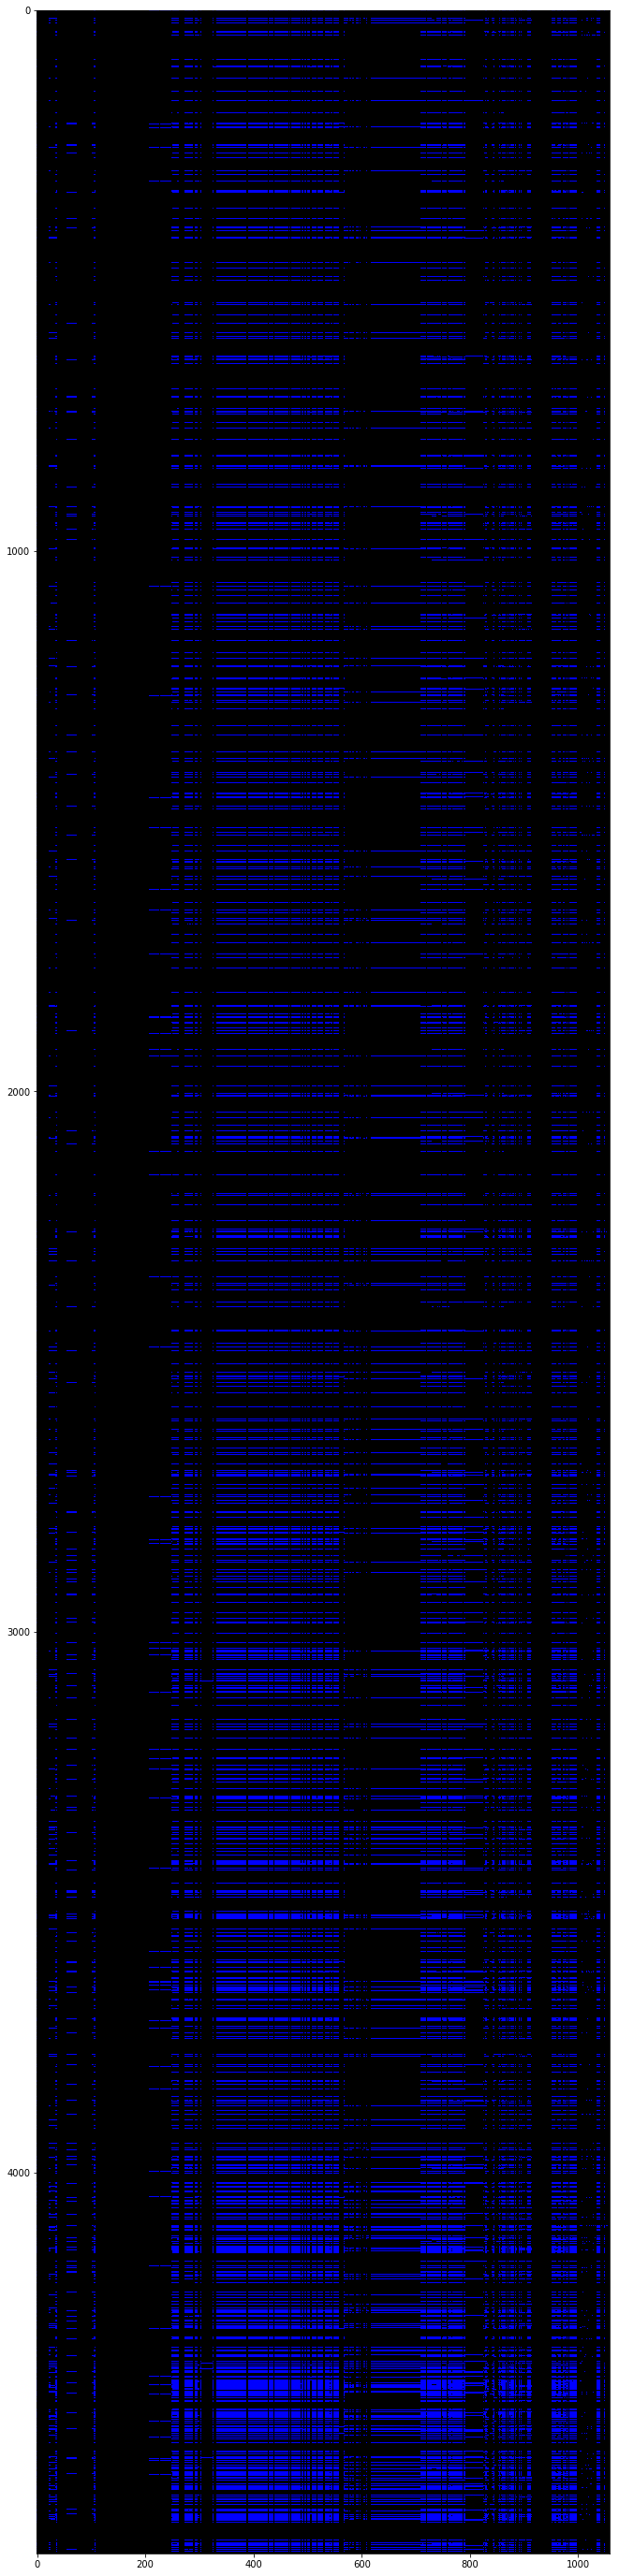

In [141]:
fig = show_visualization( comparisons )

# Step 2: New Columns, old rows

In [142]:
newly_filled = -pd.isnull( new_wave4_joined.loc[ mutual_rows, new_columns] )

In [143]:
update_comparison_figure( comparisons, chan='b', rows=mutual_rows, cols=new_columns, boolean_vals=newly_filled )

Updating b channel: 3712 rows, 20 cols, 74240 total cells
	Incoming data: 53088 true cells, 71.51%
	Existing data: selection: 0.0 px on, 0.00%, whole channel: 464415.0 px on 9.33%
	Figure after update: 53088.0 px on, 71.51% of selection, 1.07% of channel; whole channel 517503.0 px on, 10.40%


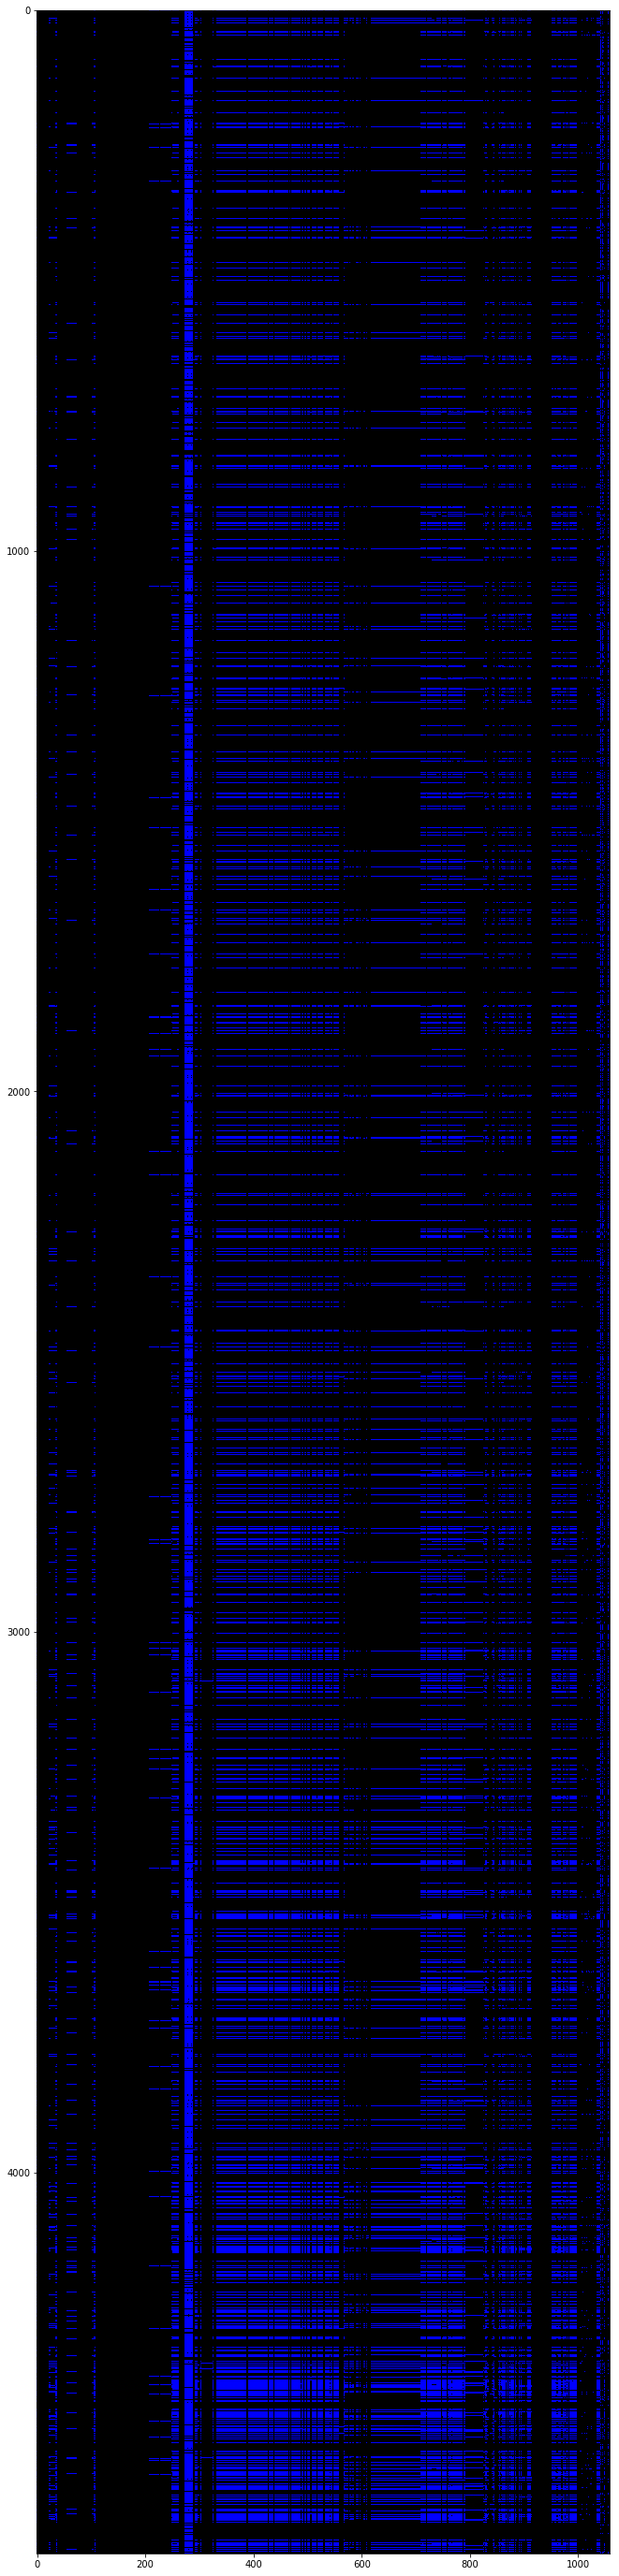

In [144]:
fig = show_visualization( comparisons )

# Of rows and columns that we had before, how many empty spots did we fill?

In [145]:
newly_filled = pd.isnull( old_wave4.loc[ mutual_rows, mutual_columns ] ) & \
                - pd.isnull( new_wave4_joined.loc[ mutual_rows, mutual_columns ] )

In [146]:
newly_filled.shape

(3712, 1038)

In [147]:
update_comparison_figure( comparisons, chan='b', rows=mutual_rows, cols=mutual_columns, boolean_vals=newly_filled )

Updating b channel: 3712 rows, 1038 cols, 3853056 total cells
	Incoming data: 338936 true cells, 8.80%
	Existing data: selection: 0.0 px on, 0.00%, whole channel: 517503.0 px on 10.40%
	Figure after update: 338936.0 px on, 8.80% of selection, 6.81% of channel; whole channel 856439.0 px on, 17.20%


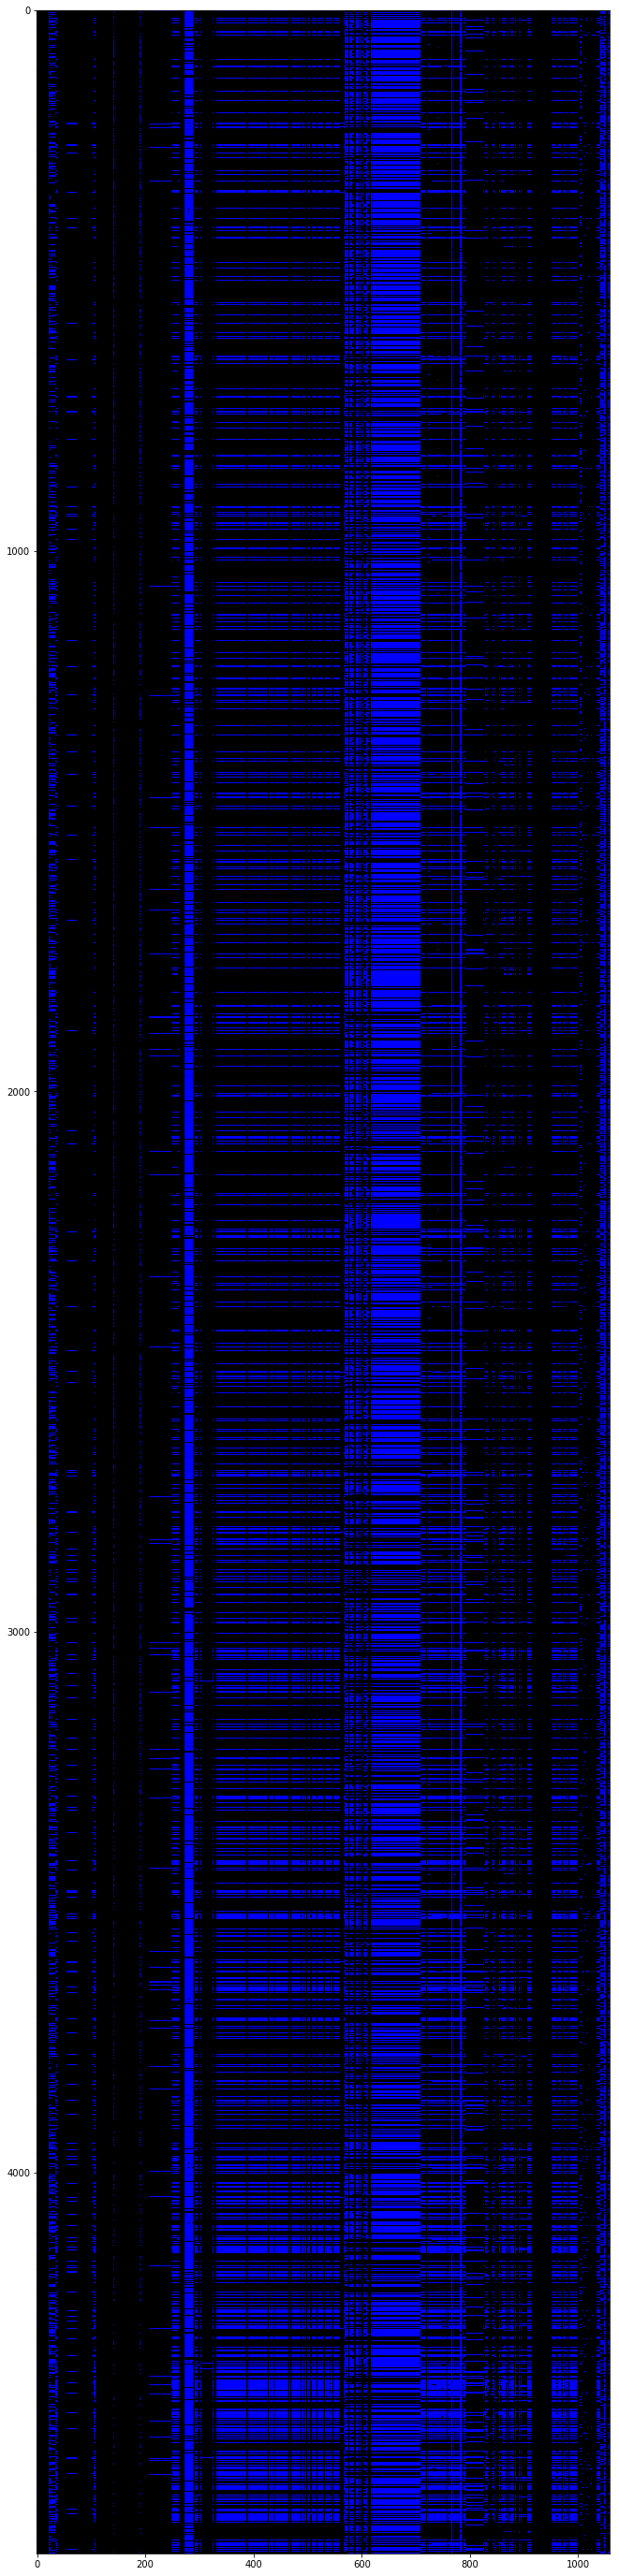

In [148]:
fig = show_visualization( comparisons )

# Newly Empty

In [149]:
newly_empty = - pd.isnull( old_wave4.loc[ mutual_rows, mutual_columns ] ) & \
              pd.isnull( new_wave4_joined.loc[ mutual_rows, mutual_columns ] )

In [150]:
pd.set_option( 'max_rows', None)

## Need to examine these columns, why are they empty since the last upload?

In [151]:
newly_empty.sum()[ newly_empty.sum() != 0].sort_index()

ThirdVisitDate                11
disChkDuchennedyst          3703
disChkEpilepsy05            3703
disChkEpilepsy06            3703
disChkEpilepsy07            3703
disChkMoodDisorder          3703
disChkMultiplescler         3703
disChkSpondylitis           3703
disChkThalassemia1          3703
disChkThalassemia2          3703
disChkThalassemia3          3703
disPesonascita              1162
ecgQTC                        30
examBisKidneydxAP              1
examBisKidneydxCort            2
examBisKidneydxCortical1       2
examBisKidneydxCortical2       1
examBisKidneydxCortical3       3
examBisKidneydxLateral         3
examBisKidneydxLength          3
examBisKidneydxVolume         73
examBisKidneysxAP              1
examBisKidneysxCort            1
examBisKidneysxCortical1       1
examBisKidneysxCortical2       2
examBisKidneysxCortical3       4
examBisKidneysxLateral        72
examBisKidneysxLength          5
examBisKidneysxVolume         72
examBisThyroidLdxAP           10
examBisThy

In [152]:
newly_empty.sum().sum()

41032

In [153]:
update_comparison_figure( comparisons, chan='r', rows=mutual_rows, cols=mutual_columns, boolean_vals=newly_empty )

Updating r channel: 3712 rows, 1038 cols, 3853056 total cells
	Incoming data: 41032 true cells, 1.06%
	Existing data: selection: 0.0 px on, 0.00%, whole channel: 0.0 px on 0.00%
	Figure after update: 41032.0 px on, 1.06% of selection, 0.82% of channel; whole channel 41032.0 px on, 0.82%


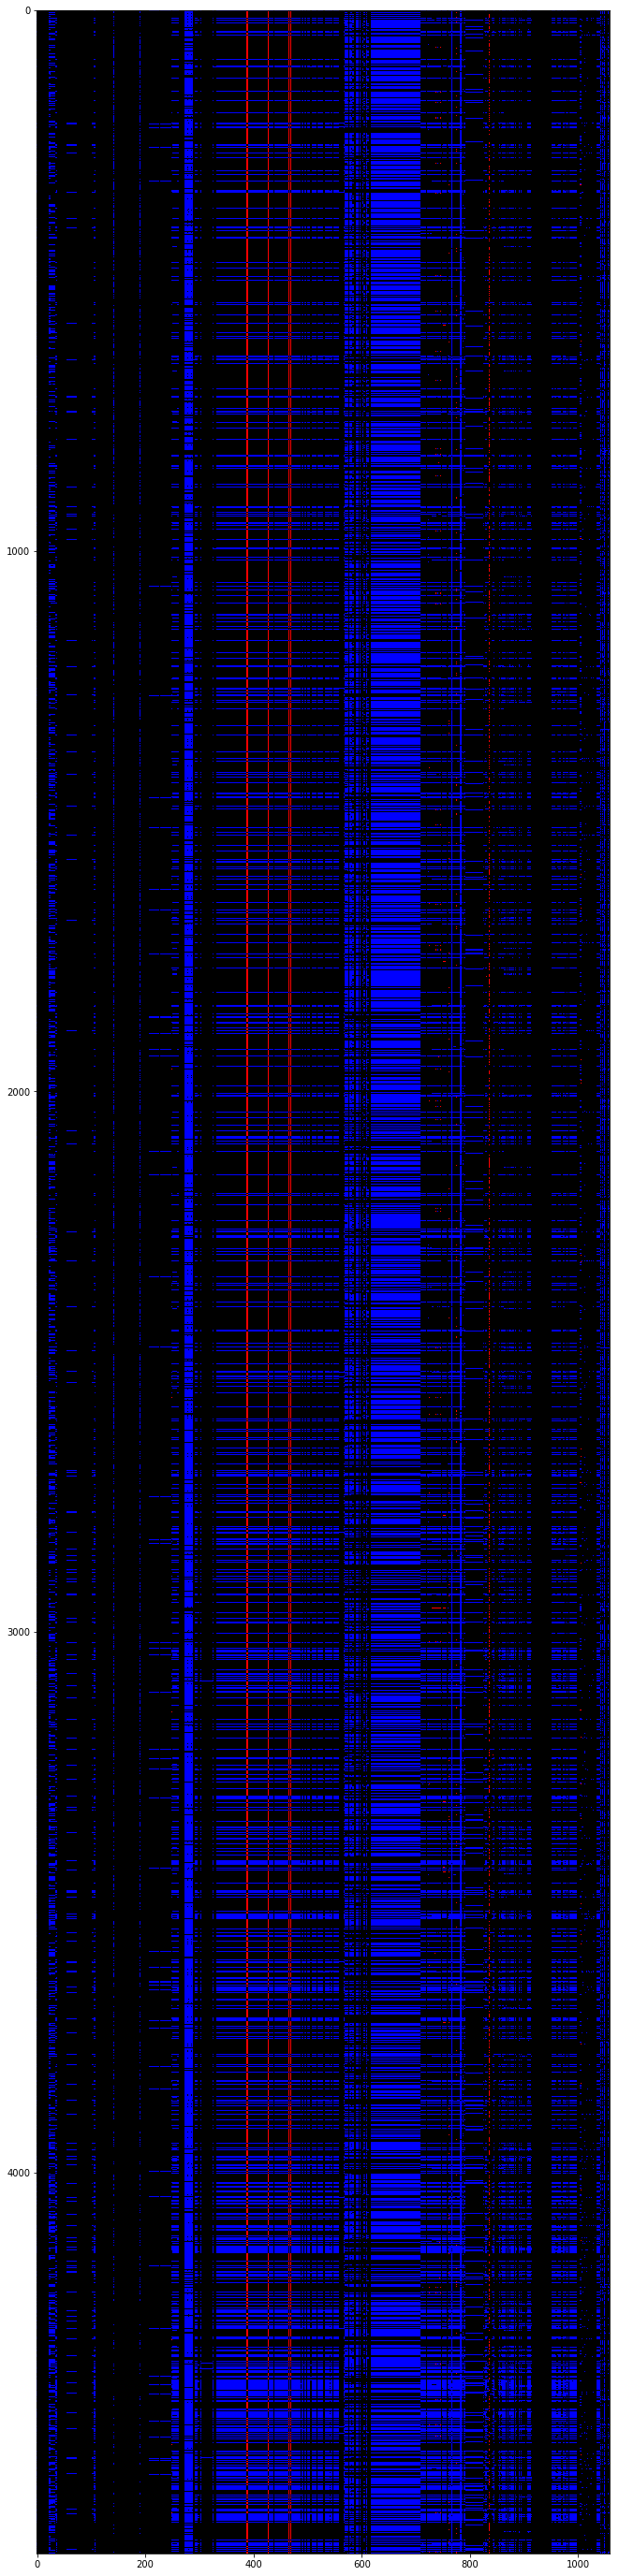

In [154]:
fig = show_visualization( comparisons )

# Check equality for non-numeric quantities

True if they're the same

Then check for not the same while ignoring empty cells in both new and old.

Yellow has RGB values R=1, G=1, B=0.

In [155]:
text_columns = list(new_wave4_joined.dtypes[ new_wave4_joined.dtypes == object].index)

In [156]:
text_cells_match = old_wave4.loc[ mutual_rows, text_columns ] == new_wave4_joined.loc[ mutual_rows, text_columns ]

In [157]:
update_comparison_figure( comparisons, chan='g', rows=mutual_rows, cols=text_columns, boolean_vals=text_cells_match )

Updating g channel: 3712 rows, 50 cols, 185600 total cells
	Incoming data: 55706 true cells, 30.01%
	Existing data: selection: 0.0 px on, 0.00%, whole channel: 0.0 px on 0.00%
	Figure after update: 55706.0 px on, 30.01% of selection, 1.12% of channel; whole channel 55706.0 px on, 1.12%


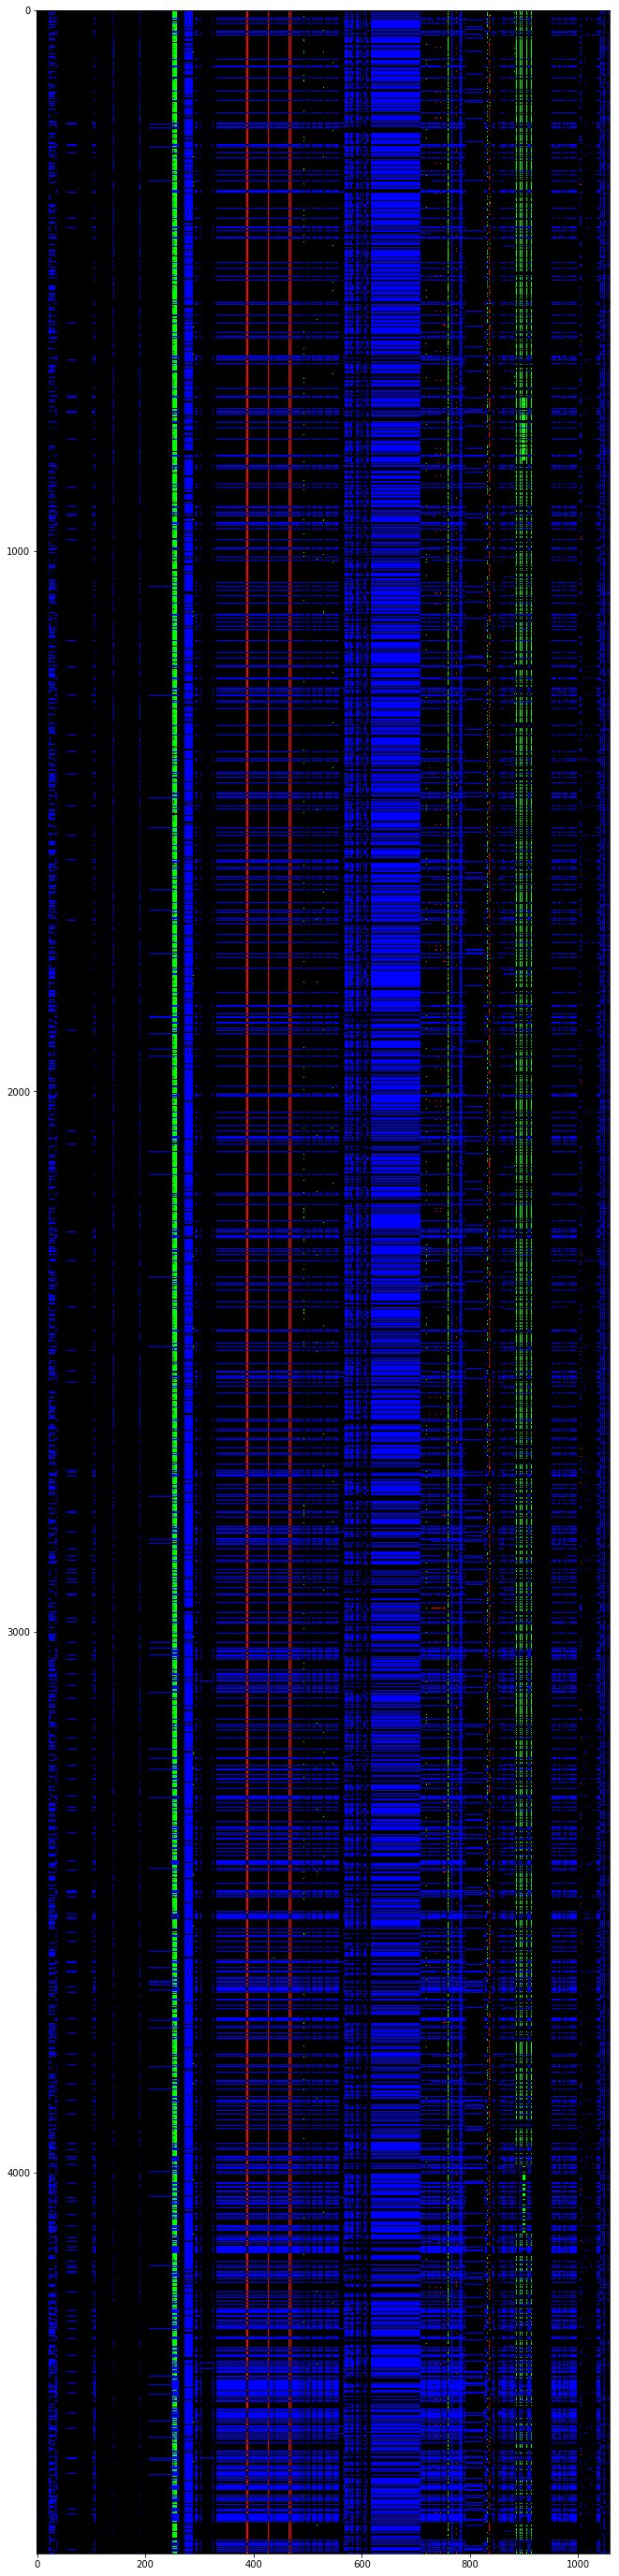

In [158]:
fig = show_visualization( comparisons )

In [159]:
# Nan's fuck shit up
np.nan != np.nan

True

In [160]:
text_cells_dont_match = \
    old_wave4.loc[ mutual_rows, text_columns ] != new_wave4_joined.loc[ mutual_rows, text_columns ] 

In [161]:
text_cells_dont_match.shape

(3712, 50)

In [162]:
old_not_null = - pd.isnull( old_wave4.loc[ mutual_rows, text_columns ] )
new_not_null = - pd.isnull( new_wave4_joined.loc[ mutual_rows, text_columns ] )

In [163]:
text_columns_not_equal = text_cells_dont_match & old_not_null & new_not_null

## Need to examine these columns, why don't they match?

In [164]:
text_columns_not_equal.sum()

FirstVisitDate          3194
FourthVisitDate         3712
SecondVisitDate         3099
ThirdVisitDate          3172
UriBilirubin               0
UriBlood                   0
UriGlucose                 0
UriGravity               892
UriKetones                 0
UriLeucocytes              0
UriNitrite                 0
UriPH                   3285
UriProtein                 0
UriUrobilinogen            0
disAPname                  2
disAPwhen                 32
disArrhythmiatype          0
disCancerOther            11
disCardcongeniteType       0
disChkOrticariat           0
disEndoOther               7
disHFname                  0
disHFwhen                 10
disHeartOther              1
disMIname                  4
disMIwhen                 25
disPesonascita           281
disSTname                  2
disSTwhen                 23
ecgNote                    2
examBisKidneyNotes       480
examBisThyroidNotes      392
exmPedidiedestra           0
exmPedidiesinistra         0
hxContraceptiv

In [165]:
update_comparison_figure( comparisons, chan='r', rows=mutual_rows, cols=text_columns, boolean_vals=text_columns_not_equal )

Updating r channel: 3712 rows, 50 cols, 185600 total cells
	Incoming data: 33198 true cells, 17.89%
	Existing data: selection: 1221.0 px on, 0.66%, whole channel: 41032.0 px on 0.82%
	Figure after update: 34419.0 px on, 18.54% of selection, 0.69% of channel; whole channel 74230.0 px on, 1.49%


In [166]:
update_comparison_figure( comparisons, chan='g', rows=mutual_rows, cols=text_columns, boolean_vals=text_columns_not_equal )

Updating g channel: 3712 rows, 50 cols, 185600 total cells
	Incoming data: 33198 true cells, 17.89%
	Existing data: selection: 55706.0 px on, 30.01%, whole channel: 55706.0 px on 1.12%
	Figure after update: 88904.0 px on, 47.90% of selection, 1.79% of channel; whole channel 88904.0 px on, 1.79%


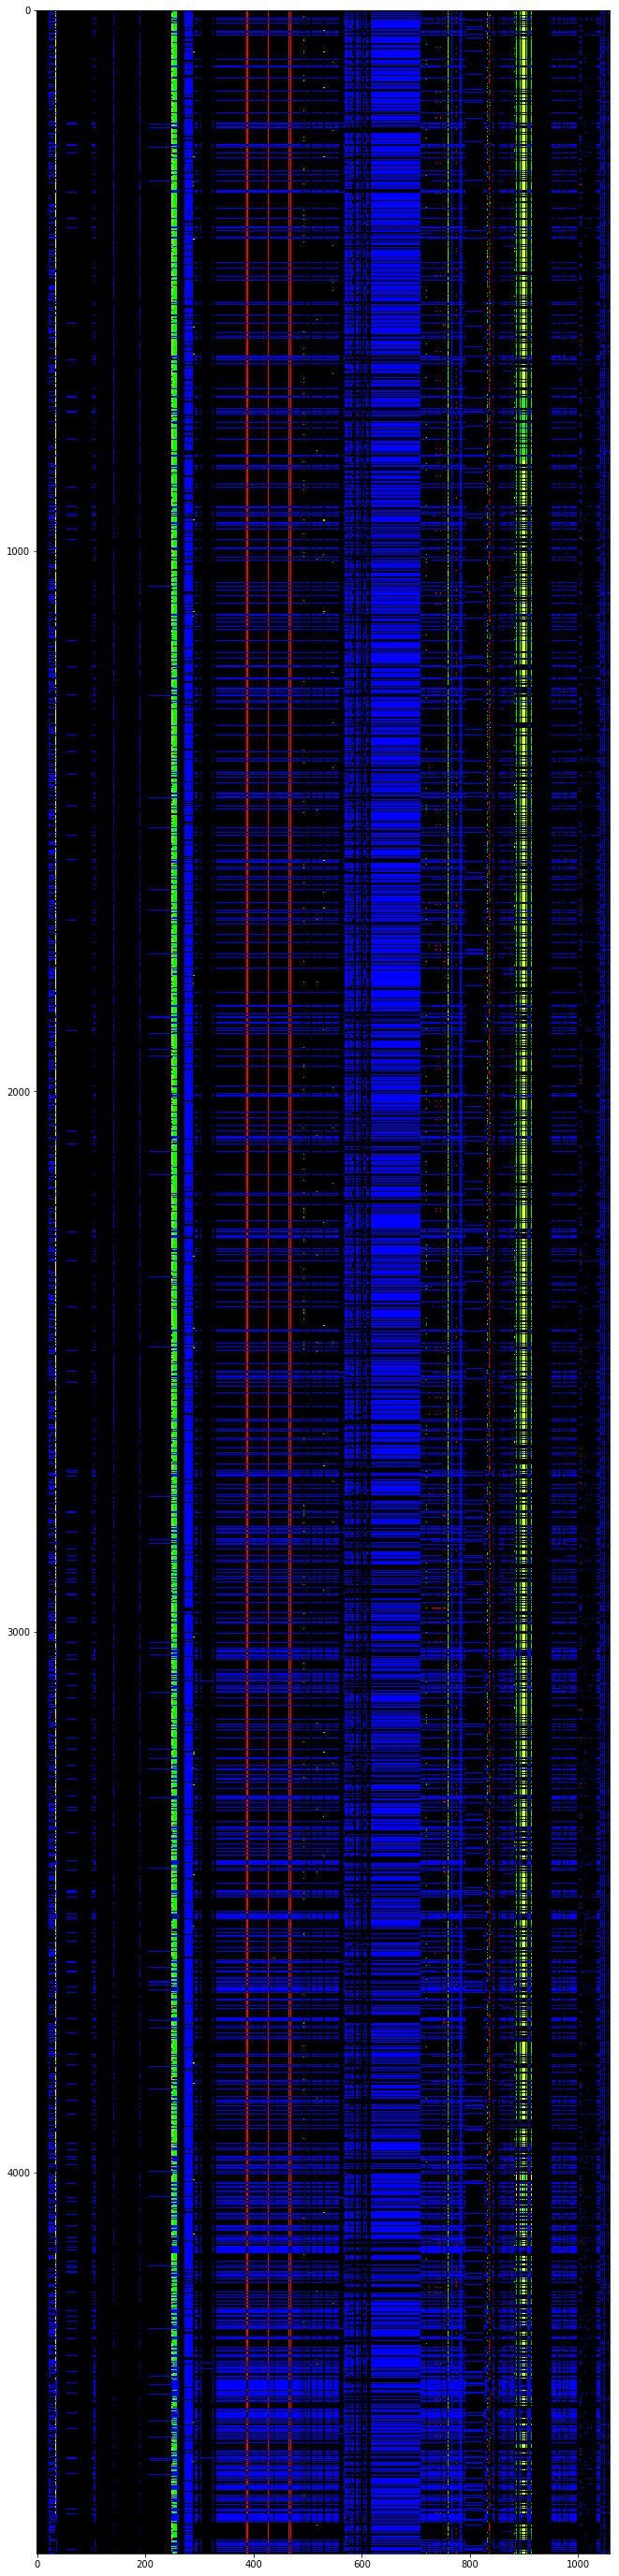

In [167]:
fig = show_visualization( comparisons )

# In existing rows, check numeric values for equality

In [168]:
numeric_columns = list(new_wave4_joined.dtypes[ new_wave4_joined.dtypes != object].index)

In [169]:
len(numeric_columns)

1008

In [170]:
len(set(numeric_columns) - new_columns)

988

In [171]:
numeric_columns = set(numeric_columns) - new_columns

In [172]:
numeric_matches = np.isclose( old_wave4.loc[ mutual_rows, numeric_columns ], new_wave4_joined.loc[ mutual_rows, numeric_columns ] )

In [173]:
numeric_matches.shape

(3712, 988)

In [174]:
numeric_matches.sum().sum()

1630193

In [175]:
update_comparison_figure( comparisons, chan='g', rows=mutual_rows, cols=numeric_columns, boolean_vals=numeric_matches )

Updating g channel: 3712 rows, 988 cols, 3667456 total cells
	Incoming data: 1630193 true cells, 44.45%
	Existing data: selection: 0.0 px on, 0.00%, whole channel: 88904.0 px on 1.79%
	Figure after update: 1630193.0 px on, 44.45% of selection, 32.75% of channel; whole channel 1719097.0 px on, 34.53%


In [176]:
old_not_null = - pd.isnull( old_wave4.loc[ mutual_rows, numeric_columns ] )
new_not_null = - pd.isnull( new_wave4_joined.loc[ mutual_rows, numeric_columns ] )
numeric_mismatch = ~numeric_matches & old_not_null & new_not_null

## Need to examine these columns, why don't they match?

In [177]:
numeric_mismatch.sum()[ numeric_mismatch.sum() != 0]

Age                              1
exmBP1sys                        2
exmWeight                        1
disChkMypia                      8
disChkEczema                     2
disChkOsteoporosis               4
examBisThyroidLdxLong            1
labsFt4                         10
examBisKidneydxCort             29
labsVES                          3
ecgQTC                        3609
exmBPdia                      2882
disChkAsthma                     2
examBisThyroidEcostructur1       1
examBisThyroidNodules            1
disChkCataract                   1
disChkDepressive                35
examBisKidneydxLength            2
pwvQual                        995
disChkAstigmatism                3
exmBP1dia                        1
examBisKidneydxVolume            4
examBisKidneydxCortical2        17
examBisKidneydxCortical3        21
examBisKidneydxCortical1        22
labsInsulinemia                  9
exmBMI                           1
hxPregnancies                    1
disChkSubAbuse      

In [178]:
update_comparison_figure( comparisons, chan='g', rows=mutual_rows, cols=numeric_columns, boolean_vals=numeric_mismatch )

Updating g channel: 3712 rows, 988 cols, 3667456 total cells
	Incoming data: 16228 true cells, 0.44%
	Existing data: selection: 1630193.0 px on, 44.45%, whole channel: 1719097.0 px on 34.53%
	Figure after update: 1646421.0 px on, 44.89% of selection, 33.07% of channel; whole channel 1735325.0 px on, 34.86%


In [179]:
update_comparison_figure( comparisons, chan='r', rows=mutual_rows, cols=numeric_columns, boolean_vals=numeric_mismatch )

Updating r channel: 3712 rows, 988 cols, 3667456 total cells
	Incoming data: 16228 true cells, 0.44%
	Existing data: selection: 39811.0 px on, 1.09%, whole channel: 74230.0 px on 1.49%
	Figure after update: 56039.0 px on, 1.53% of selection, 1.13% of channel; whole channel 90458.0 px on, 1.82%


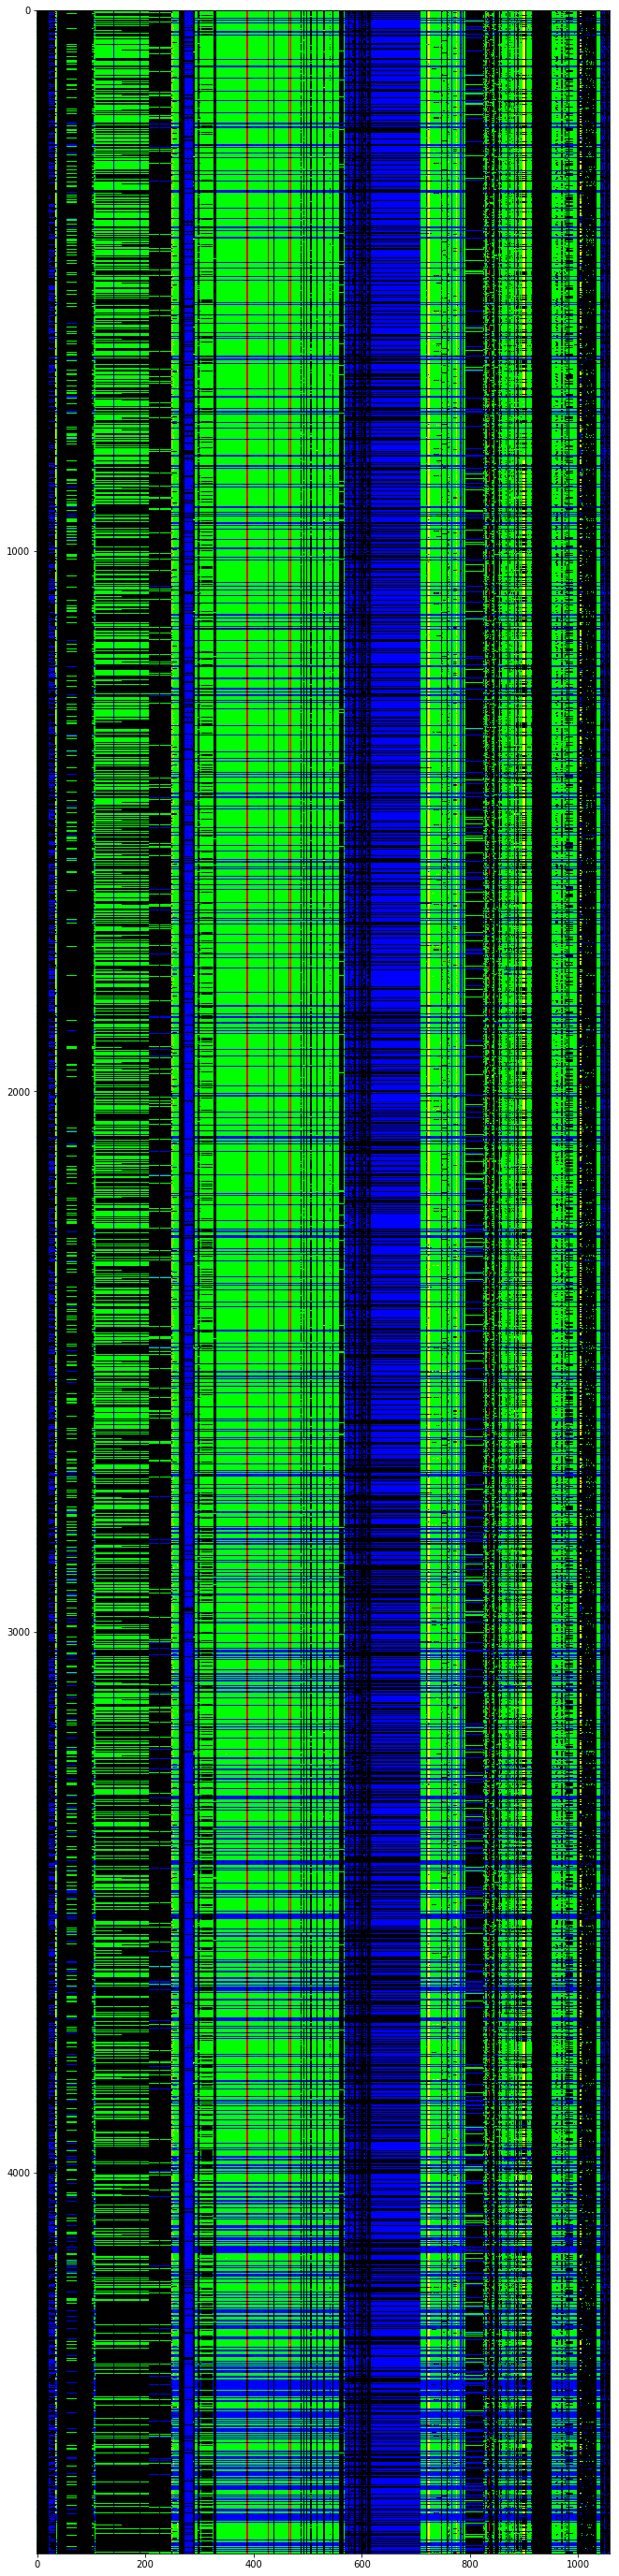

In [180]:
fig = show_visualization( comparisons )

In [181]:
fig.savefig( 'SardiNIA_database_Wave4_2015-2017_Comparison.png')

In [182]:
!ls -lh SardiNIA_database_Wave4_2015-2017_Comparison.png

-rw-r--r--  1 colettace  staff   210K Feb 15 17:34 SardiNIA_database_Wave4_2015-2017_Comparison.png
